# Importing Libraries

In [2]:
pip install tensorflow==2.9.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/tumour/data.zip

Archive:  /content/drive/MyDrive/tumour/data.zip
   creating: data/
   creating: data/test/
   creating: data/test/no/
  inflating: data/test/no/no0.jpg    
  inflating: data/test/no/no1.jpg    
  inflating: data/test/no/no10.jpg   
  inflating: data/test/no/no100.jpg  
  inflating: data/test/no/no101.jpg  
  inflating: data/test/no/no102.jpg  
  inflating: data/test/no/no103.jpg  
  inflating: data/test/no/no104.jpg  
  inflating: data/test/no/no105.jpg  
  inflating: data/test/no/no106.jpg  
  inflating: data/test/no/no107.jpg  
  inflating: data/test/no/no108.jpg  
  inflating: data/test/no/no109.jpg  
  inflating: data/test/no/no11.jpg   
  inflating: data/test/no/no110.jpg  
  inflating: data/test/no/no111.jpg  
  inflating: data/test/no/no112.jpg  
  inflating: data/test/no/no113.jpg  
  inflating: data/test/no/no114.jpg  
  inflating: data/test/no/no115.jpg  
  inflating: data/test/no/no116.jpg  
  inflating: data/test/no/no117.jpg  
  inflating: data/test/no/no118.jpg  
  infla

---

# Color

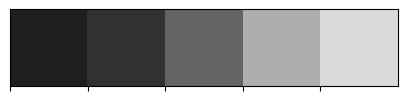

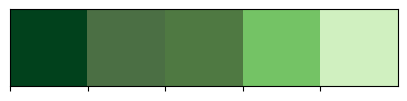

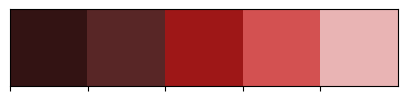

In [6]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [7]:
labels = ['yes','no']

In [8]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/data/','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/data/','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 710/710 [00:00<00:00, 993.99it/s]


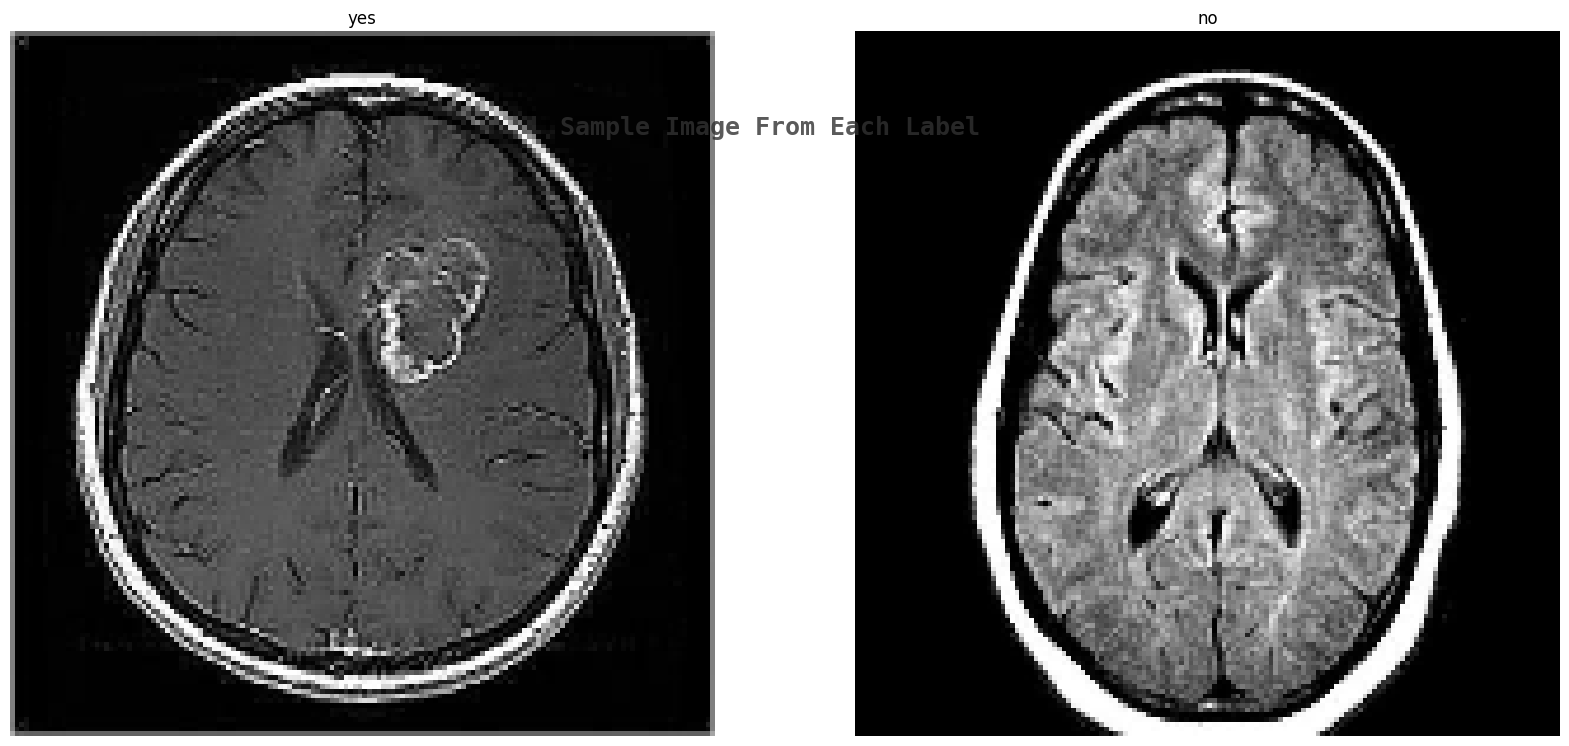

In [9]:
k=0
fig, ax = plt.subplots(1,2,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [10]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [11]:
X_train.shape

(4461, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [13]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

In [14]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [15]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [19]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [20]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =4, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/4
113/113 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9521
Epoch 1: val_accuracy improved from -inf to 0.97015, saving model to effnet.h5
113/113 [==============================] - 446s 4s/step - loss: 0.1129 - accuracy: 0.9521 - val_loss: 0.1408 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 2/4
113/113 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9850
Epoch 2: val_accuracy improved from 0.97015 to 0.99005, saving model to effnet.h5
113/113 [==============================] - 450s 4s/step - loss: 0.0432 - accuracy: 0.9850 - val_loss: 0.0622 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/4
113/113 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9934
Epoch 3: val_accuracy improved from 0.99005 to 0.99502, saving model to effnet.h5
113/113 [==============================] - 435s 4s/step - loss: 0.0241 - accuracy: 0.9934 - val_loss: 0.0371 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 4/4
113/113 [==================

In [ ]:
from warnings import filterwarnings

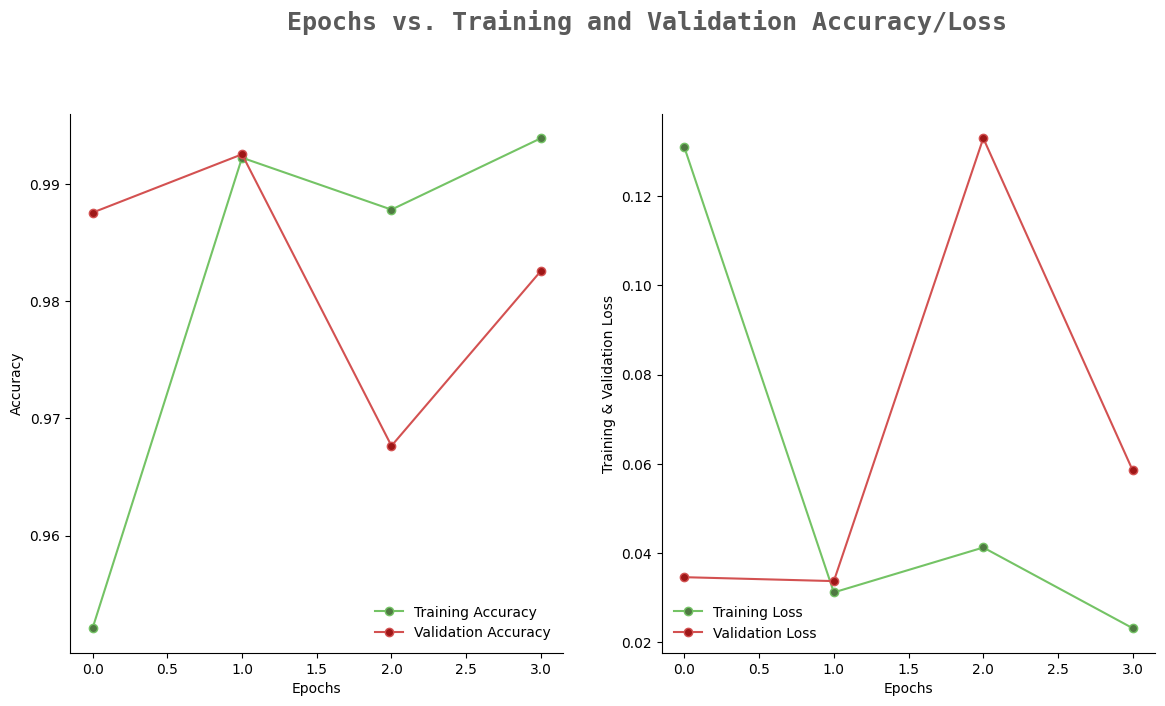

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(4)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

14/14 [==============================] - 12s 806ms/step


---

# Evaluation

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       219
           1       0.97      1.00      0.98       228

    accuracy                           0.98       447
   macro avg       0.98      0.98      0.98       447
weighted avg       0.98      0.98      0.98       447



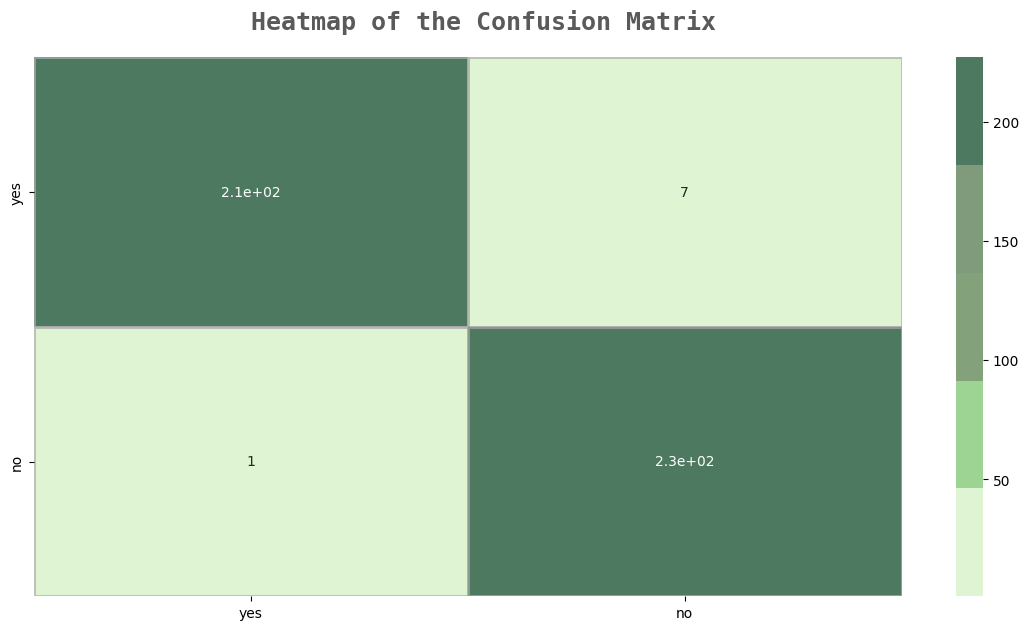

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

# Bonus Content: Widgets

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Tumour'
    elif p==1:
        print('The model predicts that there is No tumour')
    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

---